In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd

import gurobipy as gp
from gurobipy import GRB

print("imported all packages")

imported all packages


In [15]:
airports100=pd.read_csv('airports100.csv')
demandMat=pd.read_csv('demandMatrix.csv',header=None).to_numpy()
lengthMat=pd.read_csv('lengthMatrix.csv',header=None).to_numpy()
usaOutline=pd.read_csv('usaOutline.csv',header=None)
airportx=airports100['Longitude']
airporty=airports100['Latitude']

In [18]:
#define selectedges function, which outputs matrix X of optimal edges

def selectedges(N,numedges,lami,laml): #takes inputs N (# nodes), E (# edges), lambda I, lambda L
    D=demandMat[0:N,0:N]
    L=lengthMat[0:N,0:N]
    DlL=D-laml*L

    mymodel = gp.Model()
    x = mymodel.addMVar(shape=(N,N), vtype=GRB.BINARY)

    for i in range(N):
        mymodel.addConstr(x[i,i]==0)
    mymodel.addConstr(x==x.T)
    mymodel.addConstr(sum(sum(x))==2*numedges)

    y = mymodel.addMVar(shape=(N,N), vtype=GRB.BINARY)
    
    A = mymodel.addMVar(shape=(N,N), vtype=GRB.BINARY) #x==0
    mymodel.addConstr(A==1-x)
    
    B = mymodel.addMVar(shape=(N,N), vtype=GRB.INTEGER) #x@x
    mymodel.addConstr(B==x@x)
    
    C = mymodel.addMVar(shape=(N,N), vtype=GRB.BINARY) #x@x is positive
    for i in range(N):
        for j in range(N):
            mymodel.addGenConstrIndicator(C[i,j], True, B[i,j], GRB.GREATER_EQUAL, 1)
            mymodel.addGenConstrIndicator(C[i,j], False, B[i,j], GRB.EQUAL, 0)

    for i in range(N):
        for j in range(N):
            mymodel.addGenConstrAnd(y[i,j],[A[i,j],C[i,j]]) #Y=AND(A,C)

    mymodel.setObjective(sum(sum(DlL*x + lami*D*y)), GRB.MAXIMIZE)
    mymodel.optimize()
    myedges=np.around(x.X) #remove floating point discrepancies
    
    return myedges

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 466 rows, 1125 columns and 1110 nonzeros
Model fingerprint: 0xc7f0e952
Model has 225 quadratic constraints
Model has 675 general constraints
Variable types: 0 continuous, 1125 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [8e+01, 5e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
  GenCon rhs range [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 147 rows and 0 columns
Presolve removed 0 rows and 609 columns
Presolve time: 0.01s
Presolved: 4813 rows, 1881 columns, 12354 nonzeros
Variable types: 0 continuous, 1881 integer (1776 binary)
Found heuristic solution: objective 2016370.8000

Root relaxation: objective 2.261466e+06, 864 iterations, 0.01 se

Text(0.5, 1.0, 'N=15, E=80, λI=30, λL=10')

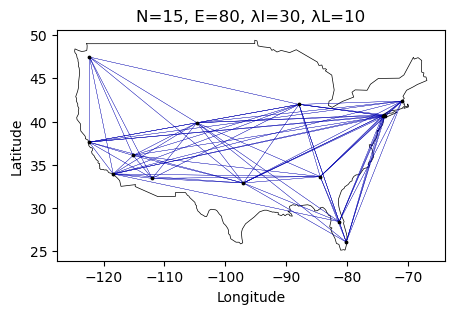

In [21]:
#execute function and graph results

N=15 #choose N 
myedges=selectedges(N,80,0.3,10) #choose the other parameters E, lambda I, lambda L

fig1, plot1 = plt.subplots()
plot1.plot(usaOutline.iloc[0,:],usaOutline.iloc[1,:],color='black',linewidth=0.5,zorder=2)
plot1.scatter(airportx[0:N],airporty[0:N],s=3,color='k',edgecolors='k',zorder=3)

for i in range(N):
    for j in range(N):
        if myedges[i,j]==1:
            plt.plot((airportx[i], airportx[j]),(airporty[i], airporty[j]),'#0000b0',linewidth=0.2)

fig1.set_size_inches(5,3)
plot1.set_xlabel('Longitude')
plot1.set_ylabel('Latitude')
plot1.set_title('N=15, E=80, λI=30, λL=10')